<a href="https://colab.research.google.com/github/mjaliz/tfztm/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.
Tere are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those pattenrs to our own data.

In [7]:
# Are we using a GPU?
!nvidia-smi

Mon Sep 25 18:05:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [8]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-25 18:05:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   206MB/s    in 0.8s    

2023-09-25 18:05:43 (206 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [9]:
# How many iamges in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [10]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing iamges:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing iamges:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things ro run while our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the mose popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (befor it trains too long and overfits) with the EarlyStopping callback

In [11]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callbaack = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callbaack

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do similar process, expect the majority of our model's layers are going to come from TensorFlow Hub.
We can access pretrained models on: https://tfhub.dev

Browsing the TensorFlow Hub page and sorting for iamge classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [12]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [13]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_rul (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  Returns:
    An uncomplied keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [15]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [41]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [42]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230925-190221
Epoch 1/5
24/24 [==============================] - 27s 544ms/step - loss: 2.0094 - accuracy: 0.3333 - val_loss: 1.2352 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 11s 466ms/step - loss: 0.9408 - accuracy: 0.7173 - val_loss: 0.8855 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 11s 482ms/step - loss: 0.6502 - accuracy: 0.8267 - val_loss: 0.7616 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 11s 469ms/step - loss: 0.5016 - accuracy: 0.8627 - val_loss: 0.7259 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 11s 470ms/step - loss: 0.3939 - accuracy: 0.9147 - val_loss: 0.6850 - val_accuracy: 0.7780


In [44]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...

import matplotlib.pyplot as plt

# Plot the validataion and traingin curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="traning loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


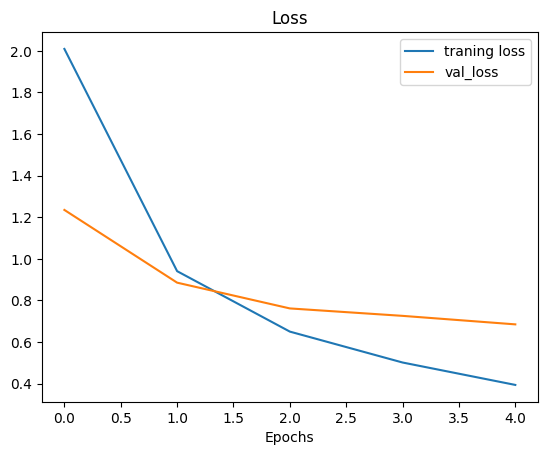

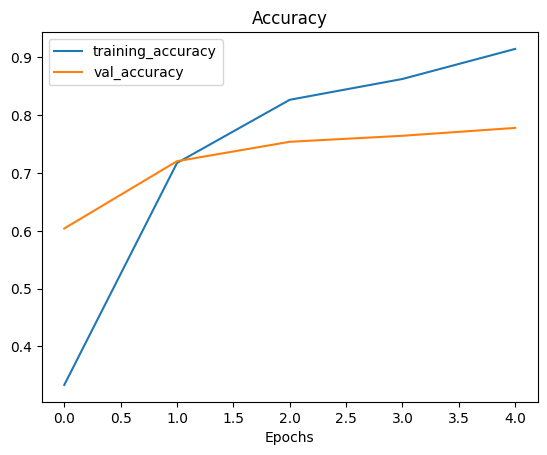

In [45]:
plot_loss_curves(resnet_history)

In [40]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [37]:
!cp -r /tmp/tfhub_modules/ /content

In [28]:
!ls

10_food_classes_10_percent	10_food_classes_10_percent.zip.1  sample_data
10_food_classes_10_percent.zip	__MACOSX


In [39]:
import shutil
shutil.make_archive("pretrained", 'zip', "/content/tfhub_modules/")

'/content/pretrained.zip'

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [50]:
# Create EfficientNetB0 feature extractor model
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Complie EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet mdoel to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              validation_data=test_data,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230925-195424
Epoch 1/5
24/24 [==============================] - 22s 473ms/step - loss: 1.9605 - accuracy: 0.3560 - val_loss: 1.4022 - val_accuracy: 0.6812
Epoch 2/5
24/24 [==============================] - 10s 430ms/step - loss: 1.1282 - accuracy: 0.7627 - val_loss: 0.9173 - val_accuracy: 0.8008
Epoch 3/5
24/24 [==============================] - 12s 536ms/step - loss: 0.7886 - accuracy: 0.8347 - val_loss: 0.7248 - val_accuracy: 0.8336
Epoch 4/5
24/24 [==============================] - 11s 464ms/step - loss: 0.6262 - accuracy: 0.8520 - val_loss: 0.6278 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 9s 393ms/step - loss: 0.5285 - accuracy: 0.8893 - val_loss: 0.5704 - val_accuracy: 0.8596


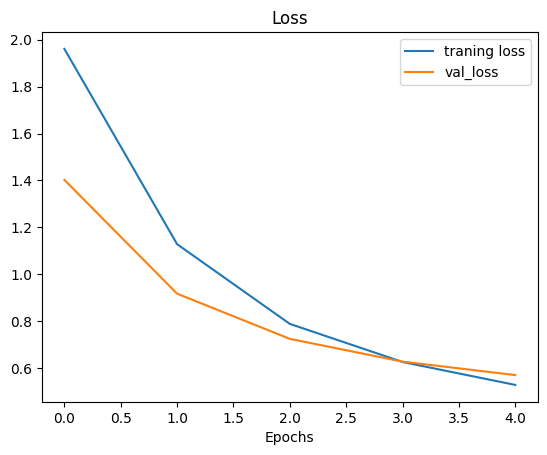

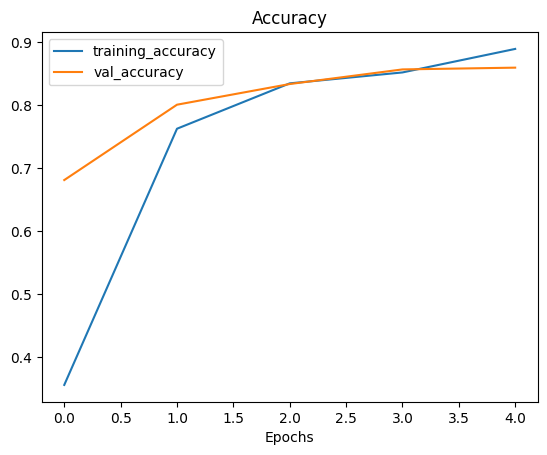

In [51]:
plot_loss_curves(efficientnet_history)

In [52]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309